In [1]:
! export PYTHONPATH="$PYTHONPATH:$HOME/generic_implementation/POISEVAE"

In [2]:
import glob 

import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F  # activation function
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

from joint_dataset import MNIST_GM
from POISEVAE import POISEVAE # Remember to do export PYTHONPATH ...
from POISEVAE import util

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['text.usetex'] = False

In [3]:
class EncMNIST(nn.Module):
    def __init__(self, latent_dim):
        super(EncMNIST, self).__init__()
        self.latent_dim = latent_dim
        self.dim_MNIST = 28 * 28

        self.enc1 = nn.Linear(self.dim_MNIST, 400)
        self.enc_mu = nn.Linear(400, latent_dim)
        self.enc_var = nn.Linear(400, latent_dim)

    def forward(self, x):
        x = F.relu(self.enc1(x))
        mu = self.enc_mu(x)
        log_var = self.enc_var(x)
        return mu, log_var

class DecMNIST(nn.Module):
    def __init__(self, latent_dim):
        super(DecMNIST, self).__init__()  
        self.latent_dim = latent_dim
        self.dim_MNIST   = 28 * 28
        
        self.dec = nn.Sequential(nn.Linear(self.latent_dim, 400), 
                                 nn.ReLU(inplace=True), 
                                 nn.Linear(400, self.dim_MNIST))
        
    def forward(self, x):
        return self.dec(x)

In [4]:
class EncGM(nn.Module):
    def __init__(self, data_dim, latent_dim):
        super(EncGM, self).__init__()
        self.latent_dim = latent_dim
        self.data_dim = data_dim
        if latent_dim > data_dim:
            raise ValueError('latent_dim > data_dim')

        self.enc = nn.Sequential(nn.Linear(data_dim, 2),
                                 nn.LeakyReLU(inplace=True))
        self.enc_mu = nn.Linear(2, latent_dim)
        self.enc_var = nn.Linear(2, latent_dim)

    def forward(self, x):
        x = self.enc(x)
        mu = self.enc_mu(x)
        log_var = self.enc_var(x)
        return mu, log_var

class DecGM(nn.Module):
    def __init__(self, data_dim, latent_dim):
        super(DecGM, self).__init__()  
        self.latent_dim = latent_dim
        self.data_dim = data_dim
        if latent_dim > data_dim:
            raise ValueError('latent_dim > data_dim')
            
        self.dec = nn.Sequential(nn.Linear(latent_dim, 2), 
                                 nn.LeakyReLU(inplace=True),
                                 nn.Linear(2, data_dim))
        
    def forward(self, x):
        return self.dec(x)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
MNIST_PATH = 'MNIST/MNIST/processed/%s.pt'

joint_dataset_train = MNIST_GM(mnist_pt_path=MNIST_PATH % 'train')
joint_dataset_test = MNIST_GM(mnist_pt_path=MNIST_PATH % 'train')

In [7]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(joint_dataset_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(joint_dataset_test, batch_size=batch_size, shuffle=True)
len(train_loader), len(test_loader)

(376, 376)

In [8]:
lat1, lat2 = 20, 1
enc_mnist = EncMNIST(lat1).to(device)
dec_mnist = DecMNIST(lat1).to(device)
enc_gm = EncGM(2, lat2).to(device)
dec_gm = DecGM(2, lat2).to(device)

def MSELoss(input, target):
    loss = nn.functional.mse_loss(input, target, reduction='sum') #/ batch_size
    return loss
    
vae = POISEVAE([enc_mnist, enc_gm], [dec_mnist, dec_gm], [MSELoss, lambda input, target: MSELoss(input, target) * 12], 
               latent_dims=[lat1, lat2]).to(device)

In [9]:
# for i in vae.named_parameters():
#     print(i[0])

In [10]:
optimizer = optim.Adam(vae.parameters(), lr=5e-3)

In [11]:
PATH = 'MNIST_GM_train_results/'

In [12]:
epoch = 0
# try:
#     vae, optimizer, epoch = load_checkpoint(vae, optimizer, sorted(glob.glob(PATH + 'train*.pt'))[-1])
# except:
#     pass

In [13]:
train_loss = []
test_loss = []
epochs = 10 + epoch
for epoch in range(epoch, epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_losses = util.train(vae, train_loader, optimizer, epoch)
    train_loss.append(train_epoch_losses)
    ret = util.test(vae, test_loader, epoch, record_idx=(2, 3), return_latents=True)
    test_epoch_losses, labels, latent_info = ret[:4], ret[-2], ret[-1]
    test_loss.append(test_epoch_losses)
    print(f"Train Loss: %.4f\n\tRec: %.4f, %.4f\n\tKLD Loss %.4f" % train_epoch_losses)
    print(f"Test Loss: %.4f\n\tRec: %.4f, %.4f\n\tKLD Loss %.4f" % test_epoch_losses)
    if (epoch+1) % 10 == 0 and epoch > 0:
        util.save_checkpoint(vae, optimizer, PATH + 'training_%d.pt' % (epoch+1), epoch+1)
train_loss = np.array(train_loss).T
test_loss = np.array(test_loss).T

Epoch 1 of 10
Train Loss: 52.2114
	Rec: 35.7618, 16.3244
	KLD Loss 0.1252
Test Loss: 42.7941
	Rec: 29.7904, 13.1588
	KLD Loss -0.1551
Epoch 2 of 10
Train Loss: 41.4453
	Rec: 28.2805, 12.7209
	KLD Loss 0.4439
Test Loss: 39.0876
	Rec: 27.6332, 11.3019
	KLD Loss 0.1525
Epoch 3 of 10
Train Loss: 36.1142
	Rec: 26.8837, 8.4634
	KLD Loss 0.7671
Test Loss: 34.1056
	Rec: 25.8815, 6.4486
	KLD Loss 1.7755
Epoch 4 of 10
Train Loss: 31.9474
	Rec: 25.7024, 5.6690
	KLD Loss 0.5759
Test Loss: 29.4435
	Rec: 24.8919, 5.0523
	KLD Loss -0.5007
Epoch 5 of 10
Train Loss: 30.1495
	Rec: 24.8915, 4.8393
	KLD Loss 0.4188
Test Loss: 29.5731
	Rec: 24.4871, 4.5236
	KLD Loss 0.5624
Epoch 6 of 10
Train Loss: 29.0377
	Rec: 24.3359, 4.4524
	KLD Loss 0.2494
Test Loss: 31.5212
	Rec: 23.8947, 4.2703
	KLD Loss 3.3561
Epoch 7 of 10
Train Loss: 28.3344
	Rec: 23.8102, 4.2426
	KLD Loss 0.2816
Test Loss: 30.3659
	Rec: 23.6484, 4.1006
	KLD Loss 2.6169
Epoch 8 of 10
Train Loss: 27.7410
	Rec: 23.4222, 4.0998
	KLD Loss 0.2190
Test

In [14]:
util.save_latent_info(latent_info, PATH)

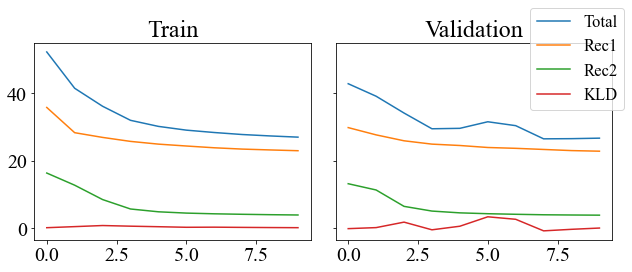

In [15]:
fig, ax = plt.subplots(ncols=2, sharex='all', sharey='all', figsize=(9, 4))

for i, label in enumerate(('Total', 'Rec1', 'Rec2', 'KLD')):
    ax[0].plot(train_loss[i], label=label)
    ax[1].plot(test_loss[i], label=label)
ax[0].set_title('Train')
ax[1].set_title('Validation')
fig.legend(*ax[0].get_legend_handles_labels(), fontsize='small')
fig.tight_layout()

In [16]:
with torch.no_grad():
    for i, data in enumerate(test_loader):
        results = vae([data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)])
        break

In [17]:
results['x_rec'][1].shape, data[1].shape

(torch.Size([128, 2]), torch.Size([128, 2]))

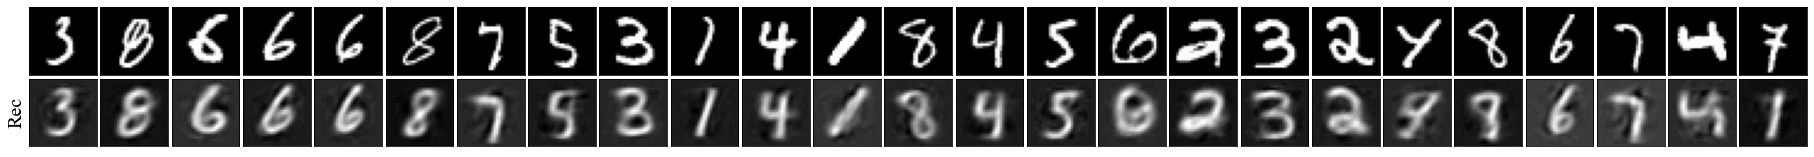

In [18]:
ncols = min(len(results['x_rec'][0]), 25)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(25, 2))
for i, aux in enumerate(zip(data[0], results['x_rec'][0])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=20)
fig.tight_layout(pad=0)

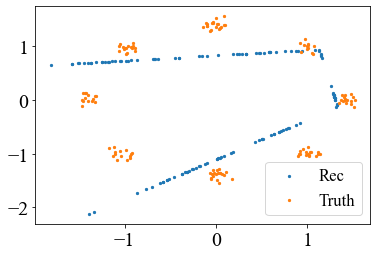

In [19]:
plt.scatter(*results['x_rec'][1].cpu().numpy().T, label='Rec', s=5)
plt.scatter(*data[1].cpu().numpy().T, label='Truth', s=5)
plt.legend(fontsize='small')